# Interpolating a dolfin.Function on a different mesh using fenicstools

**Author**: Maximilian Albert

**Date**: Jan 2014

**Purpose**: Illustrate the use of `fenicstools.interpolate_nonmatching_mesh`, which can be used to sample a `dolfin.Function` defined on a certain mesh on a completely different mesh.

It also illustrates how to create a simple sampling mesh by manually creating a very coarse mesh using `dolfin`'s `MeshEditor` and then refining it via `dolfin.refine()`.

## Installing Fenicstools

This notebook requires `fenicstools` to be installed (see https://github.com/mikaem/fenicstools/wiki). This can be done using the following steps:

1. Clone the repository from github:

    ```
    git clone https://github.com/mikaem/fenicstools.git
    
    ```    

2. If you are using dolfin 1.3.0 (as opposed to the development version 1.3.0+) then you need to check out an older version to avoid some compile errors:

    ```
    cd /path/to/fenicstools
    git checkout bb079952ee090ad46918cb381b0ca7a61c29c0ba
    ```
    
3. Add the directory containing the fenicstools repository to your PYTHONPATH:

   ```
   export PYTHONPATH=${PYTHONPATH}:/path/to/parent/directory/of/fenicstools
  
   ```
   
4. Check that the installation successed by typing in an IPython prompt:

   `>>> import fenicstools`

   This may take a while upon the first time, since it will compile some code under the hood. If you don't see an error message then the installation was successful.

## Using `fenicstools` to interpolate a function on a different mesh

### Creating a sample simulation

First we import `fenicstools` as well as `dolfin` and some relevant functions from `finmag`.

In [1]:
import fenicstools
import dolfin as df
import finmag
from finmag.util.visualization import plot_dolfin_function
from finmag.util.meshes import plot_mesh_with_paraview
finmag.set_logging_level('INFO')

[2014-06-09 21:34:17] INFO: Finmag logging output will be appended to file: '/home/albert/.finmag/global.log'
[2014-06-09 21:34:17] DEBUG: Building modules in 'native'...
[2014-06-09 21:34:18] DEBUG: FinMag          5054:1bf63877328ce1c83b5052fdb2113e35172acf42
[2014-06-09 21:34:18] DEBUG: Dolfin          1.4.0                Matplotlib      1.3.1               
[2014-06-09 21:34:18] DEBUG: Numpy           1.8.1                Scipy           0.12.0              
[2014-06-09 21:34:18] DEBUG: IPython         2.1.0                Python          2.7.5+              
[2014-06-09 21:34:18] DEBUG: Paraview        4.0.1-1              Sundials        2.5.0               
[2014-06-09 21:34:18] DEBUG: Boost-Python    <unknown>            Linux           Linux Mint 16 Petra 
[2014-06-09 21:34:18] DEBUG: Registering debug signal handler. Press Ctrl-Z at any time to stop execution and jump into the debugger.


For simplicity, we will be using the `disk` example provided by Finmag.

In [2]:
sim = finmag.example.normal_modes.disk()

[2014-06-09 21:34:19] INFO: Finmag logging output will be written to file: '/home/albert/work/code/finmag/doc/ipython_notebooks_src/normal_modes_nanodisk.log' (any old content will be overwritten).
[2014-06-09 21:34:19] INFO: Creating Sim object 'normal_modes_nanodisk' (rank=0/1).
[2014-06-09 21:34:19] INFO: <Mesh of topological dimension 3 (tetrahedra) with 333 vertices and 1016 cells, ordered>
[2014-06-09 21:34:19] INFO: Reloaded and set m (<m>=[  9.98589358e-01   9.96248224e-03  -1.63965155e-05]) and time=2.2444482928e-10 from /home/albert/work/code/finmag/src/finmag/example/normal_modes/disk_relaxed.npz.


In order to get prettier pictures we also initialise a vortex state of radius 10 nm.

In [3]:
sim.initialise_vortex('simple', r=10.0)

Let's plot the magnetisation to see what it looks like.

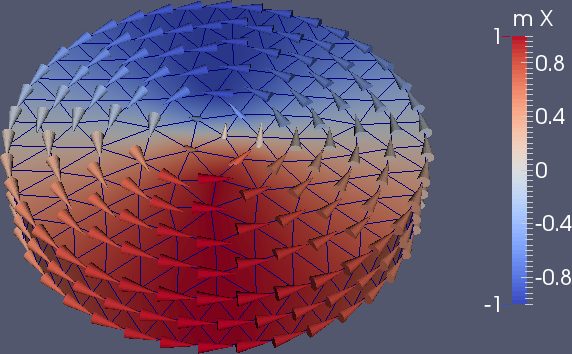

In [4]:
sim.render_scene()

### Interpolating `m` on a different mesh

We would like to get a `dolfin.Function` which represents the magnetisation, but on a different mesh. The first step is to extract the magnetisation from the simulation.

In [5]:
m = sim.get_field_as_dolfin_function('m')

Next we define the mesh on which we'd like to interpolate the magnetisation. Here we choose a 2-dimensional circular mesh. The radius of the nanodisk is 30 nm. We make the circular mesh deliberately wider to illustrate that the interpolated function will simply be set to zero in the region where `m` is not defined.

In [6]:
mesh2 = df.CircleMesh(df.Point(0, 0), 50.0, 10.0)

Next we need to define the function space on this new mesh into which `m` is going to be interpolated. We are using Lagrange elements of degree 1, but have to use `dim=3` because the magnetisation is a 3-dimensional vector (even though the mesh itself is 2-dimensional).

In [7]:
V2 = df.VectorFunctionSpace(mesh2, 'CG', 1, dim=3)

Finally, we can interpolate the magnetisation on the new mesh.

In [8]:
m2 = fenicstools.interpolate_nonmatching_mesh(m, V2)

Let's plot the newly obtained dolfin function `m2`. As mentioned above, we can see that outside the region where `m` was defined it is simply set to zero.

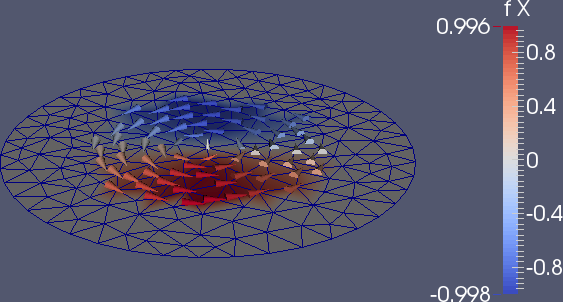

In [10]:
plot_dolfin_function(m2, camera_position=[0, -100, 50])

### Interpolating `m` on yet another mesh

This section illustrates that interpolation works even for quite crazy meshes. Here we construct a mesh which represents a planar section in space. This mesh has topological dimension 2 (since it represents a plane) but geometrical dimension 3 (since it "lives" in 3-dimensional space).

We construct it by defining a very coase mesh which only consists of 2 triangular cells. We use `dolfin`'s built-in `MeshEditor` class to define the mesh.

In [11]:
# Define an emtpy mesh
mesh3_coarse = df.Mesh()

# Open this empty mesh in the MeshEditor, specifying
# the topological and geometrical dimensions
editor = df.MeshEditor()
editor.open(mesh3_coarse, 2, 3)  # topological dimension=2, geometrical dimension=3

# Tell the MeshEditor the number of vertices and cells
editor.init_vertices(4)
editor.init_cells(2)

# Add the four vertices by specifying their coordinates
editor.add_vertex(0, np.array([0, +50, -5], dtype=float))
editor.add_vertex(1, np.array([0, -50, -5], dtype=float))
editor.add_vertex(2, np.array([0, -50, +15], dtype=float))
editor.add_vertex(3, np.array([0, +50, +15], dtype=float))

# Add the two triangular cells by specifying the indices
# of the vertices for each triangle.
editor.add_cell(0, np.array([0, 1, 2], dtype='uint'))
editor.add_cell(1, np.array([0, 2, 3], dtype='uint'))

# Close the editor, which finishes mesh creation
editor.close()

If we plot this mesh we can see that it indeed represents a planar section in space.

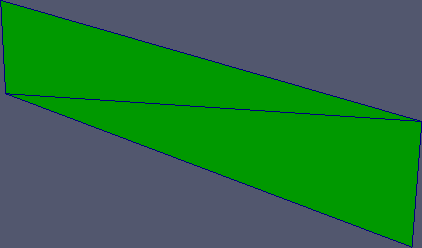

In [12]:
plot_mesh_with_paraview(mesh3_coarse, camera_position=[-100, -100, 50])

Since we'd like to have a finer sampling of the magnetisation on this mesh, we refine it a few times using `dolfin`'s `refine` command.

In [13]:
mesh3 = df.refine(df.refine(df.refine(df.refine(mesh3_coarse))))

Plotting the refined mesh we see that it represents the same plane in space but has a lot more cells.

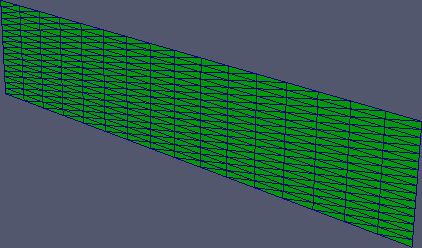

In [14]:
plot_mesh_with_paraview(mesh3, camera_position=[-100, -100, 50])

We define a new function space `V3` on this mesh and interpolate `m` into this function space using `fenicstools`.

In [15]:
V3 = df.VectorFunctionSpace(mesh3, 'CG', 1, dim=3)
m3 = fenicstools.interpolate_nonmatching_mesh(m, V3)

Plotting the new function `m3` we see that it indeed represents a vertical cross-section through the disk.

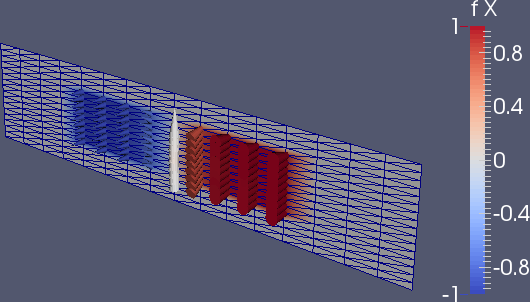

In [17]:
plot_dolfin_function(m3, glyph_scale_factor=5, camera_position=[-100, -100, 50])